In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import entropy
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from matplotlib.colors import hsv_to_rgb


In [2]:
data = []
labels = []
paths = []
file_name = []

target_size = (100, 100)

for sub_folder in os.listdir("Citra Daun Padi\\"):
    sub_folder_files = os.listdir(os.path.join("Citra Daun Padi\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("Citra Daun Padi\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        img = cv.resize(img, target_size)

        data.append(img)
        
        labels.append(sub_folder)
        paths.append(img_path)
        file_name.append(filename)

data = np.array(data)
labels = np.array(labels)
paths = np.array(paths)

## Data Preparation

In [3]:
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	data_augmented.append(data[i])
	labels_augmented.append(labels[i])
	paths_augmented.append(paths[i])
	file_name_augmented.append(file_name[i])
	data_augmented.append(cv.rotate(data[i], cv.ROTATE_90_CLOCKWISE))
	labels_augmented.append(labels[i])
	paths_augmented.append(paths[i])
	file_name_augmented.append(file_name[i])

In [4]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  500
Data setelah augmentasi:  1000


### Preprocessing

In [5]:
def bgr2gray(image):
    tinggi, lebar = image.shape[:2]
    grayImg = np.zeros((tinggi, lebar)).astype(np.uint8)
    for i in range(tinggi):
        for j in range(lebar):
            grayImg[i,j] = int(0.2989*image[i][j][2] + 0.5870*image[i][j][1] + 0.1140*image[i][j][0])
            
    return grayImg

In [6]:
def mergeRGB(red, green, blue):
    return np.dstack((red, green, blue)).astype(np.uint8)

def masking(image, mask):
    new_img = image.copy()
    new_img[mask == 0] = 0
    return new_img

def bgr2hsv(image):
    tinggi, lebar = image.shape[:2]
    hsvImg = np.zeros((tinggi, lebar, 3)).astype(np.uint8)
    for i in range(tinggi):
        for j in range(lebar):
            b, g, r = image[i][j]
            r, g, b = r/255.0, g/255.0, b/255.0
            cmax = max(r, g, b)
            cmin = min(r, g, b)
            delta = cmax - cmin
            if delta == 0:
                h = 0
            elif cmax == r:
                h = 30 * (((g-b)/delta) % 6)
            elif cmax == g:
                h = 30 * (((b-r)/delta) + 2)
            elif cmax == b:
                h = 30 * (((r-g)/delta) + 4)
            if cmax == 0:
                s = 0
            else:
                s = delta / cmax
            v = cmax
            hsvImg[i,j] = [h, s*255, v*255]
    return hsvImg

def inRange(hsv, lower_color, upper_color):
    mask = np.logical_and(hsv >= lower_color, hsv <= upper_color)
    return np.all(mask, axis=-1).astype(np.uint8) * 255

## remove baground

In [7]:
def remove_background(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower_color = np.array([20, 0, 20])
    upper_color = np.array([150, 200, 255])
    mask = inRange(hsv, lower_color, upper_color)
    res = cv.bitwise_and(img, img, mask=mask)
    tinggi, lebar = res.shape[:2]
    imageRes= np.full((tinggi, lebar), 255)
    imageRes[res[:,:,0] != 0] = 0
    red = masking(img[:,:,2], imageRes)
    green = masking(img[:,:,1], imageRes)
    blue = masking(img[:,:,0], imageRes)
    hasil = mergeRGB(blue, green, red)
    return hasil

In [8]:
for sub_folder in os.listdir("Citra Daun Padi\\"):
    sub_folder_files = os.listdir(os.path.join("Citra Daun Padi\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("Citra Daun Padi\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = remove_background(img) 
        name = os.path.splitext(filename)[0]
        output_dir = os.path.join("hasil1\\", sub_folder)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        cv.imwrite(os.path.join(output_dir, filename), img)


### melakukan clasifikasi

In [9]:
# Mendefinisikan kategori penyakit padi
Categories = ['blast', 'blight', 'tungro']
flat_data_arr = []
target_arr = []
datadir = './hasil1'

# Memuat data citra dan label dari setiap kategori penyakit
for category in Categories:
    print(f'memuat... kategori: {category}')
    path = os.path.join(datadir, category)
    for img in os.listdir(path):
        img_array = imread(os.path.join(path, img))
        img_resized = resize(img_array, (150, 150, 3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(category))
    print(f'loaded category: {category} BERHASIL')

# Mengonversi data menjadi array numpy
flat_data = np.array(flat_data_arr)
target = np.array(target_arr)

memuat... kategori: blast
loaded category: blast BERHASIL
memuat... kategori: blight
loaded category: blight BERHASIL
memuat... kategori: tungro
loaded category: tungro BERHASIL


In [10]:
df = pd.DataFrame(flat_data)
df['Target'] = target
df.shape

(500, 67501)

In [11]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=77, stratify=y)

print("Jumlah Data Training:", x_train.shape[0])
print("Jumlah Data Testing:", x_test.shape[0])

Jumlah Data Training: 400
Jumlah Data Testing: 100


In [13]:
# Membuat dan melatih model Naive Bayes
nb_classifier = GaussianNB()
nb_classifier.fit(x_train, y_train)

GaussianNB()

In [14]:
y_pred = nb_classifier.predict(x_test)

In [15]:
accuracy = accuracy_score(y_pred, y_test)
print(f"The model is {accuracy*100}% accurate")
print(classification_report(y_test, y_pred, target_names=Categories))

The model is 56.00000000000001% accurate
              precision    recall  f1-score   support

       blast       0.49      0.68      0.57        40
      blight       0.71      0.61      0.66        44
      tungro       0.29      0.12      0.17        16

    accuracy                           0.56       100
   macro avg       0.50      0.47      0.47       100
weighted avg       0.55      0.56      0.54       100



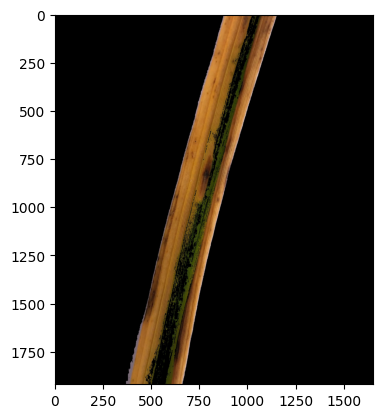

blast = 0.0%
blight = 0.0%
tungro = 100.0%
The predicted image is: tungro


In [17]:
path = './hasil1/tungro/IMG_0414.jpg'
img = imread(path)
plt.imshow(img)
plt.show()
img_resize = resize(img, (150, 150, 3))
l = [img_resize.flatten()]
prediction = nb_classifier.predict(l)[0]
probability = nb_classifier.predict_proba(l)[0]

for ind, val in enumerate(Categories):
    print(f'{val} = {probability[ind]*100}%')

print("The predicted image is: " + Categories[prediction])